In [1]:
import os
from glob import glob

from fitsio import FITS
from astropy.io import fits, ascii
from astropy.table import Table, hstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from cycler import cycler
plt.rcParams.update({
    'figure.figsize'   : (12, 10),
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   : 5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 7,
    'ytick.major.size' : 7,
    'xtick.major.width': 3,
    'ytick.major.width': 3,
    'xtick.minor.size' : 5,
    'ytick.minor.size' : 5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'lines.linewidth'  : 3,
    'axes.prop_cycle'  : cycler('color', ['red', 'orange', 'teal', 'skyblue']),
})

def Table_to_array(table):
    tuple_data = table.as_array()
    list_data  = [list(values) for values in tuple_data]
    array_data = np.array(list_data, dtype = np.float32)

    return array_data

def normalized_arrays(x_values, y_values):

    dx = x_values[1] - x_values[0] #assuming x is linear
    norm_factor = np.sum(y_values * dx)
    norm_y_values = y_values/norm_factor
    return x_values, norm_y_values

In [2]:
folder = '/data2/lsajkov/mpdg/saved_soms/09Aug24_mag_cut_20p5'
KiDS_predicted = FITS(f'{folder}/predicted_catalog.fits')[1]

labeled_map = np.load(f'{folder}/labeled_map.npy',
                      allow_pickle = True)
labeled_map_values = np.load(f'{folder}/labeled_map_values.npy',
                      allow_pickle = True)
data_bmus = np.load(f'{folder}/data_bmus.npy',
                      allow_pickle = True)
labeling_bmus = np.load(f'{folder}/labeling_bmus.npy',
                      allow_pickle = True)

In [3]:
steps = 250
min_z = 0; max_z = 0.4
min_mstar = 6; max_mstar = 12

In [4]:
def gauss(x, mu, sigma): return 1/np.sqrt(2 * np.pi * sigma**2) * np.exp(-(x - mu)**2/(2 * sigma**2))

Text(0.5, 0, '$z$')

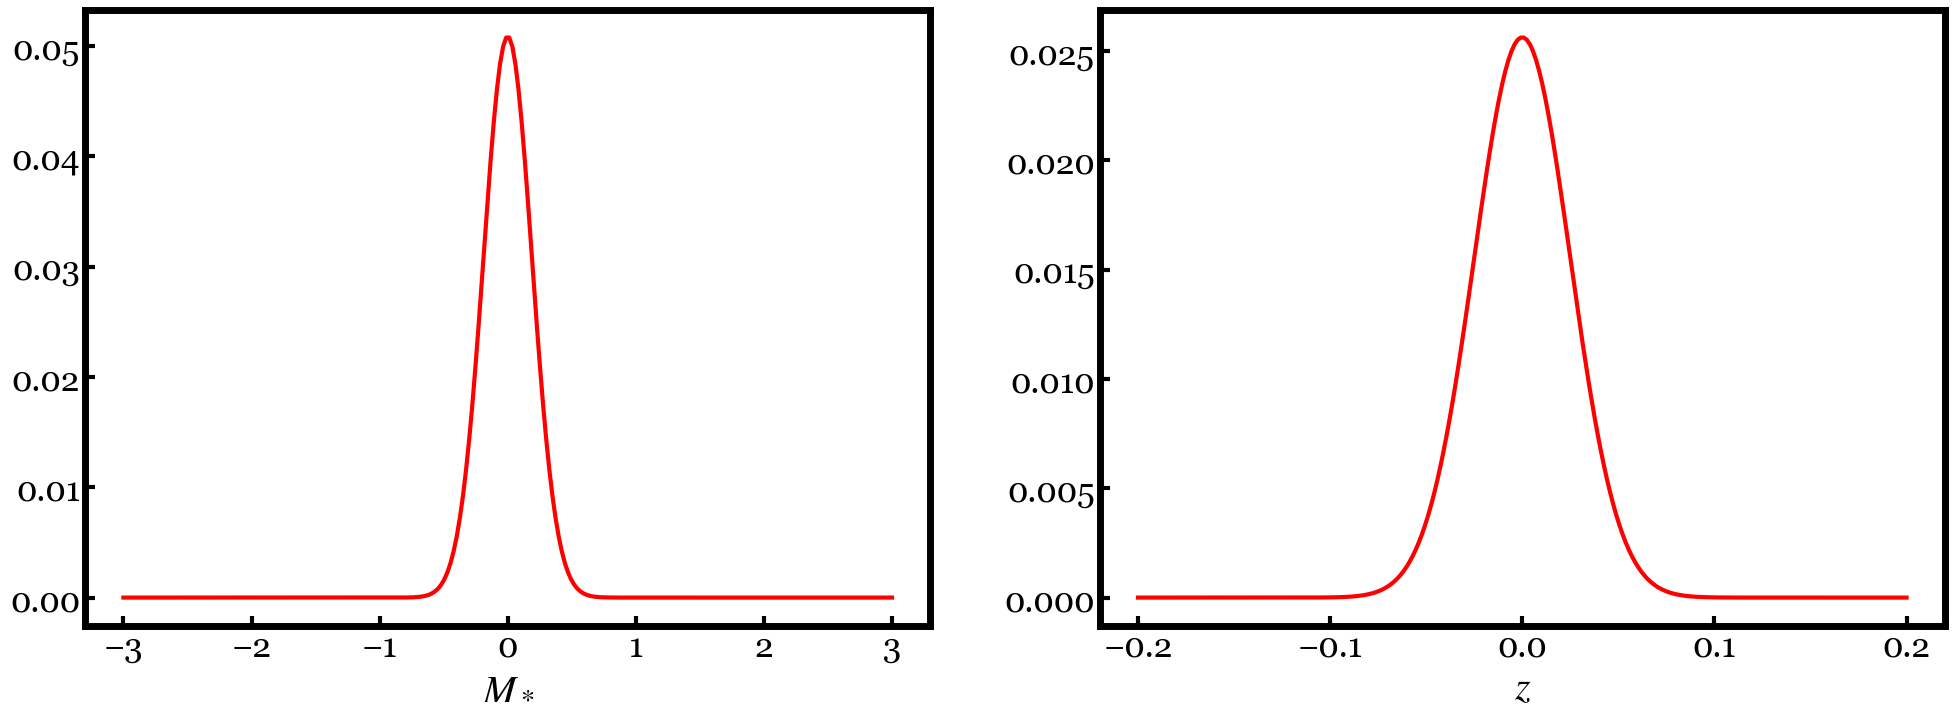

In [5]:
redshift_sigma = 0.025
redshift_gaussian = 1/np.sqrt(2 * np.pi * redshift_sigma ** 2) *\
                    np.exp(-(np.linspace(min_z, max_z, steps) - (max_z - min_z)/2) ** 2/(2 * redshift_sigma**2))
redshift_gaussian /= np.sum(redshift_gaussian)

mstar_sigma = 0.189
mstar_gaussian = 1/np.sqrt(2 * np.pi * mstar_sigma ** 2) *\
                 np.exp(-(np.linspace(min_mstar, max_mstar, steps) - (max_mstar + min_mstar)/2) ** 2/(2 * mstar_sigma**2))
mstar_gaussian /= np.sum(mstar_gaussian)

fig = plt.figure(figsize = (24, 8))
ax_l = fig.add_subplot(121)
ax_l.plot(np.linspace(min_mstar, max_mstar, steps) - (max_mstar + min_mstar)/2, mstar_gaussian)
ax_l.set_xlabel('$M_*$')

ax_r = fig.add_subplot(122)
ax_r.plot(np.linspace(min_z, max_z, steps) - (min_z + max_z)/2, redshift_gaussian)
ax_r.set_xlabel('$z$')

In [6]:
mstar_lo = labeled_map[..., 1] < 8.75
mstar_md = (labeled_map[..., 1] >= 8.75) & (labeled_map[..., 1] < 9.5)
mstar_hi = labeled_map[..., 1] >= 9.5

In [7]:
weights = np.zeros_like(labeled_map[..., 0])
for cell, _ in np.ndenumerate(weights):
    weights[cell] = np.sum(np.all(data_bmus == cell, axis = 1))

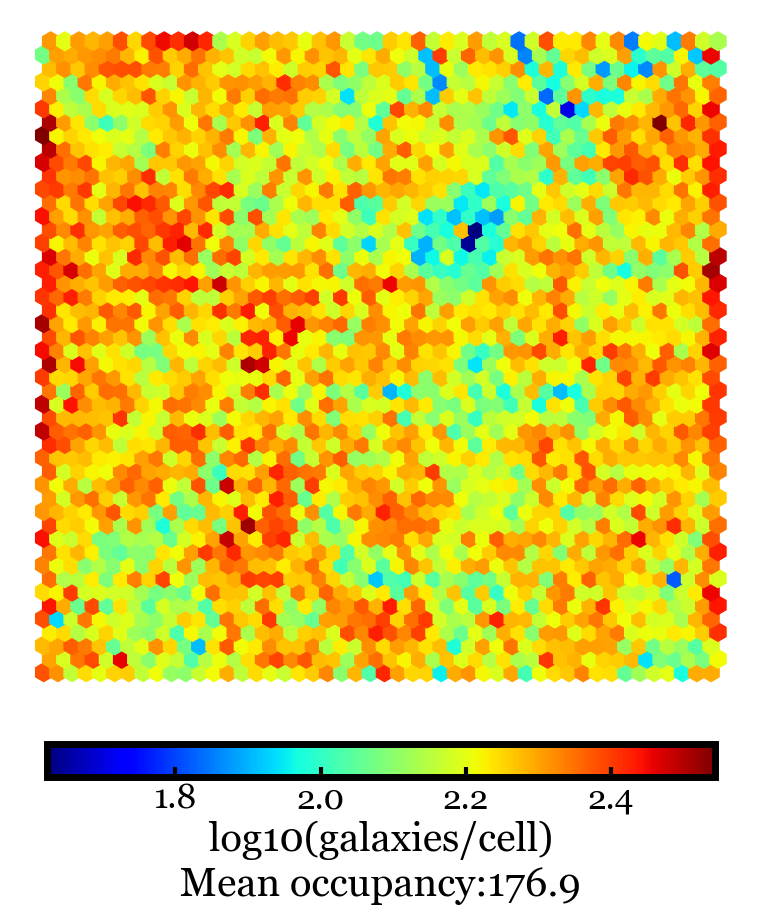

In [9]:
n_rows = n_columns = 48

hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                      np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

occupancy_map = np.empty((n_rows, n_columns), dtype = float)
for index, values in np.ndenumerate(labeled_map_values[..., 0]):
    if len(values) > 0:
        occupancy_map[index] = len(values)
    else: occupancy_map[index] = np.nan

fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
ax = fig.add_subplot()
ax.axis('off')

map = ax.scatter(*hexmesh, c = np.log10(weights), marker = 'h', cmap = 'jet', s = 180)
fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'log10(galaxies/cell)\nMean occupancy:{np.nanmean(weights):.1f}', shrink = 0.9)

# fig.savefig(f'{folder_name}/occupancy_map.png', bbox_inches = 'tight')

In [11]:
#mstar lo bin
mstar_lo_weights = weights[mstar_lo]

#redshift
mstar_lo_zs = labeled_map_values[mstar_lo, 0]
mstar_lo_z_dist = np.zeros(steps)

all_weights = np.array([])
for cell_idx, cell in enumerate(mstar_lo_zs):
    values = np.histogram(cell, bins = np.linspace(min_z, max_z, steps))[0]
    dist_in_cell = np.convolve(values, redshift_gaussian/np.sum(redshift_gaussian), mode = 'same')
    weight_in_cell = mstar_lo_weights[cell_idx]
    mstar_lo_z_dist += dist_in_cell * weight_in_cell
    all_weights = np.append(all_weights, weight_in_cell)

mstar_lo_z_dist /= np.sum(all_weights)

#mstar
mstar_lo_mstars = labeled_map_values[mstar_lo, 1]
mstar_lo_mstar_dist = np.zeros(steps)

all_weights = np.array([])
for cell_idx, cell in enumerate(mstar_lo_mstars):
    values = np.histogram(np.log10(cell), bins = np.linspace(min_mstar, max_mstar, steps))[0]
    dist_in_cell = np.convolve(values, mstar_gaussian/np.sum(mstar_gaussian), mode = 'same')
    weight_in_cell = mstar_lo_weights[cell_idx]
    mstar_lo_mstar_dist += dist_in_cell * weight_in_cell**2
    all_weights = np.append(all_weights, weight_in_cell)

mstar_lo_mstar_dist /= np.sum(all_weights**2)

In [12]:
#mstar md bin
mstar_md_weights = weights[mstar_md]

#redshift
mstar_md_zs = labeled_map_values[mstar_md, 0]
mstar_md_z_dist = np.zeros(steps)

all_weights = np.array([])
for cell_idx, cell in np.ndenumerate(mstar_md_zs):
    values = np.histogram(cell, bins = np.linspace(min_z, max_z, steps))[0]
    dist_in_cell = np.convolve(values, redshift_gaussian/np.sum(redshift_gaussian), mode = 'same')
    weight_in_cell = mstar_md_weights[cell_idx]
    mstar_md_z_dist += dist_in_cell * weight_in_cell
    all_weights = np.append(all_weights, weight_in_cell)

mstar_md_z_dist /= np.sum(all_weights)

#mstar
mstar_md_mstars = labeled_map_values[mstar_md, 1]
mstar_md_mstar_dist = np.zeros(steps)

all_weights = np.array([])
for cell in mstar_md_mstars:
    values = np.histogram(np.log10(cell), bins = np.linspace(min_mstar, max_mstar, steps))[0]
    dist_in_cell = np.convolve(values, mstar_gaussian/np.sum(mstar_gaussian), mode = 'same')
    weight_in_cell = mstar_md_weights[cell_idx]
    mstar_md_mstar_dist += dist_in_cell * weight_in_cell
    all_weights = np.append(all_weights, weight_in_cell)

mstar_md_mstar_dist /= np.sum(all_weights)

In [13]:
#mstar hi bin
mstar_hi_weights = weights[mstar_hi]

#redshift
mstar_hi_zs = labeled_map_values[mstar_hi, 0]
mstar_hi_z_dist = np.zeros(steps)

all_weights = np.array([])
for cell in mstar_hi_zs:
    values = np.histogram(cell, bins = np.linspace(min_z, max_z, steps))[0]
    dist_in_cell = np.convolve(values, redshift_gaussian/np.sum(redshift_gaussian), mode = 'same')
    weight_in_cell = mstar_hi_weights[cell_idx]
    mstar_hi_z_dist += dist_in_cell * weight_in_cell
    all_weights = np.append(all_weights, weight_in_cell)

mstar_hi_z_dist /= np.sum(all_weights)

#mstar
mstar_hi_mstars = labeled_map_values[mstar_hi, 1]
mstar_hi_mstar_dist = np.zeros(steps)

all_weights = np.array([])
for cell in mstar_hi_mstars:
    values = np.histogram(np.log10(cell), bins = np.linspace(min_mstar, max_mstar, steps))[0]
    dist_in_cell = np.convolve(values, mstar_gaussian/np.sum(mstar_gaussian), mode = 'same')
    weight_in_cell = mstar_hi_weights[cell_idx]
    mstar_hi_mstar_dist += dist_in_cell * weight_in_cell
    all_weights = np.append(all_weights, weight_in_cell)

mstar_hi_mstar_dist /= np.sum(all_weights)

In [14]:
def median_of_dist(x, p_x):
    dx = x[1] - x[0]

    cdf = np.array([np.sum(dx * p_x[:i]) for i in range(len(x))])
    cdf_half = cdf <= 1/2

    approx_median = x[cdf_half][-1]

    return approx_median 

In [15]:
x_z = np.linspace(min_z, max_z, steps)
_, z_pdf_lo = normalized_arrays(x_z, mstar_lo_z_dist)
z_median_lo = median_of_dist(x_z, z_pdf_lo)

_, z_pdf_md = normalized_arrays(x_z, mstar_md_z_dist)
z_median_md = median_of_dist(x_z, z_pdf_md)

_, z_pdf_hi = normalized_arrays(x_z, mstar_hi_z_dist)
z_median_hi = median_of_dist(x_z, z_pdf_hi)

x_mstar = np.linspace(min_mstar, max_mstar, steps)
_, mstar_pdf_lo = normalized_arrays(x_mstar, mstar_lo_mstar_dist)
mstar_median_lo = median_of_dist(x_mstar, mstar_pdf_lo)

_, mstar_pdf_md = normalized_arrays(x_mstar, mstar_md_mstar_dist)
mstar_median_md = median_of_dist(x_mstar, mstar_pdf_md)

_, mstar_pdf_hi = normalized_arrays(x_mstar, mstar_hi_mstar_dist)
mstar_median_hi = median_of_dist(x_mstar, mstar_pdf_hi)

In [16]:
KiDS_SOM_n_z_bin1 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO1_Nz.asc')
KiDS_SOM_n_z_bin2 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO2_Nz.asc')
KiDS_SOM_n_z_bin3 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO3_Nz.asc')
KiDS_SOM_n_z_bin4 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO4_Nz.asc')
KiDS_SOM_n_z_bin5 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO5_Nz.asc')

<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
/var/tmp/lsajkov/ipykernel_739979/1676687372.py:36: SyntaxWarning: invalid escape sequence '\l'
  ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_739979/1676687372.py:37: SyntaxWarning: invalid escape sequence '\l'
  ax_r.set_ylabel('$p(\log_{10}(M_*/M_{\odot}))$')


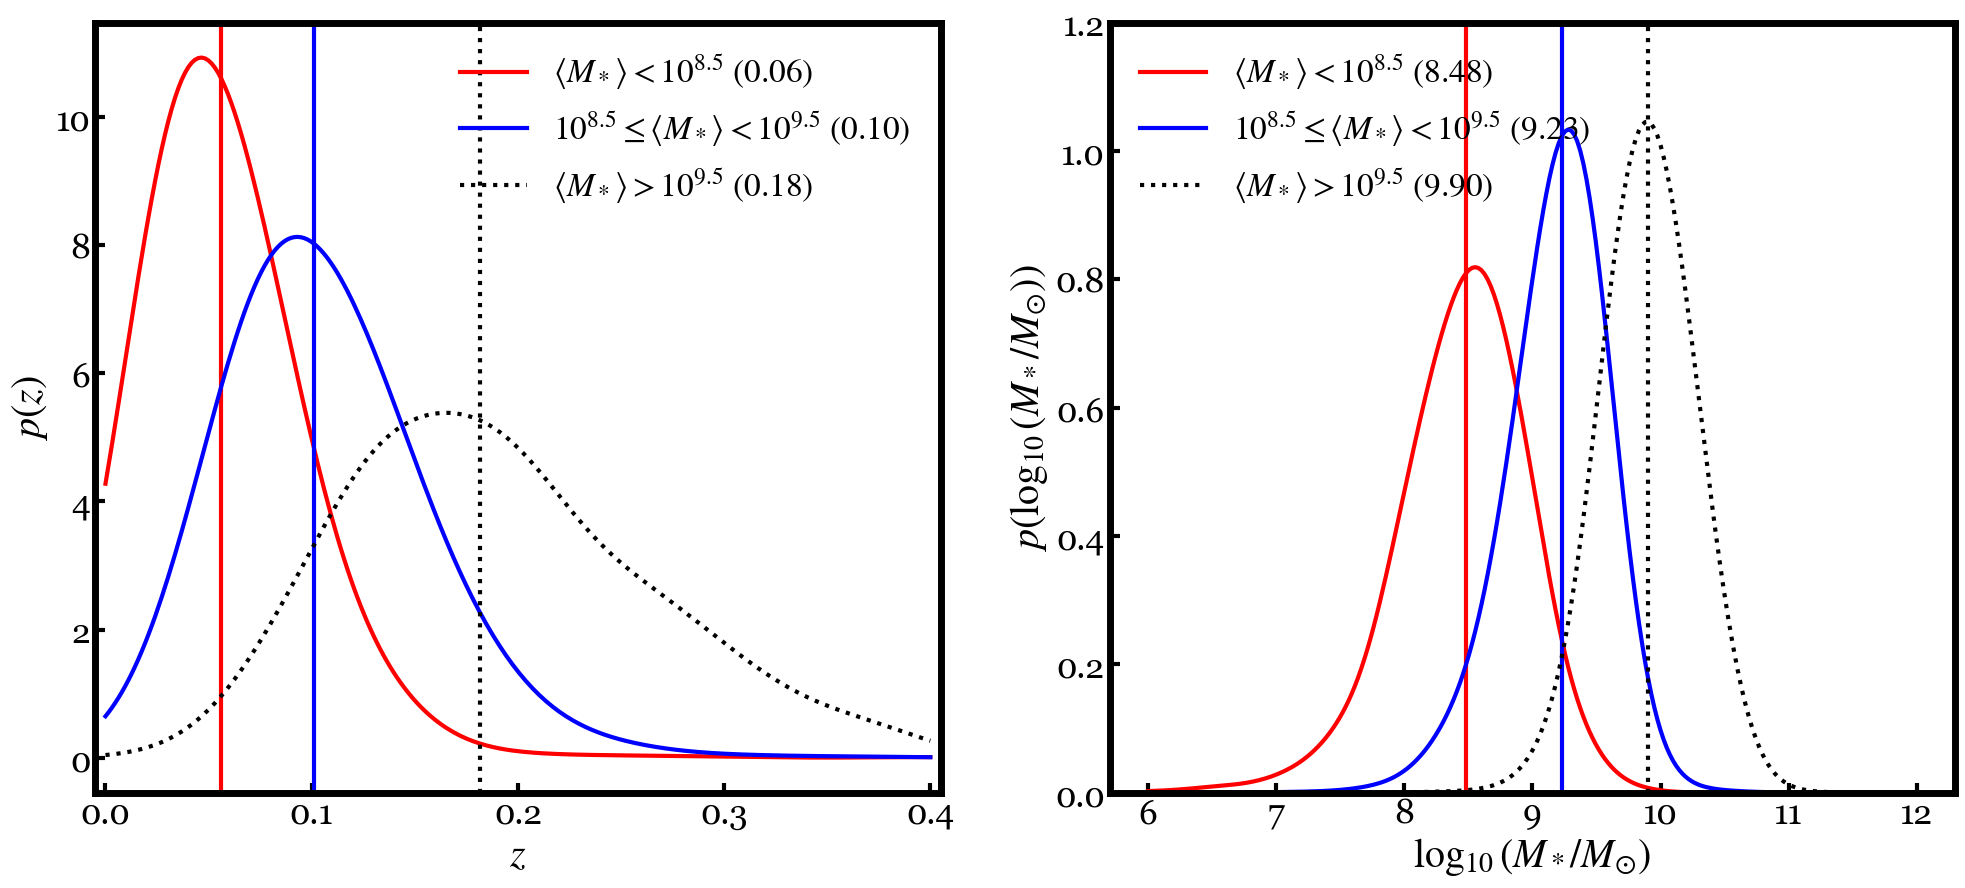

In [17]:
fig = plt.figure(figsize = (24, 10))
ax_l = fig.add_subplot(121)

ax_l.plot(x_z, z_pdf_lo,
    color = 'red', label = rf'$\langle M_* \rangle < 10^{{8.5}}\ ({z_median_lo:.2f})$')
ax_l.axvline(z_median_lo, color = 'red')

ax_l.plot(x_z, z_pdf_md, color = 'blue', label = rf'$10^{{8.5}} \leq \langle M_* \rangle < 10^{{9.5}}\ ({z_median_md:.2f})$')
ax_l.axvline(z_median_md, color = 'blue')

ax_l.plot(x_z, z_pdf_hi, color = 'black', linestyle = ':', label = rf'$\langle M_* \rangle > 10^{{9.5}}\ ({z_median_hi:.2f})$')
ax_l.axvline(z_median_hi, color = 'black', linestyle = ':')

ax_l.set_xlim(-0.005, 0.405)
# ax_l.set_ylim(0, 0.270)

ax_l.set_xlabel('$z$')
ax_l.set_ylabel('$p(z)$')

ax_l.legend(frameon = False)

ax_r = fig.add_subplot(122)

ax_r.plot(x_mstar, mstar_pdf_lo, color = 'red', label = rf'$\langle M_* \rangle < 10^{{8.5}}\ ({mstar_median_lo:.2f})$')
ax_r.axvline(mstar_median_lo, color = 'red')

ax_r.plot(x_mstar, mstar_pdf_md, color = 'blue', label = rf'$10^{{8.5}} \leq \langle M_* \rangle < 10^{{9.5}}\ ({mstar_median_md:.2f})$')
ax_r.axvline(mstar_median_md, color = 'blue')

ax_r.plot(x_mstar, mstar_pdf_hi, color = 'black', linestyle = ':', label = fr'$\langle M_* \rangle > 10^{{9.5}}\ ({mstar_median_hi:.2f})$')
ax_r.axvline(mstar_median_hi, color = 'black', linestyle = ':')

ax_r.set_ylim(0, 1.2)
# ax_r.set_yticklabels([])

ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')
ax_r.set_ylabel('$p(\log_{10}(M_*/M_{\odot}))$')

ax_r.legend(frameon = False)

fig.subplots_adjust(wspace = 0.2)

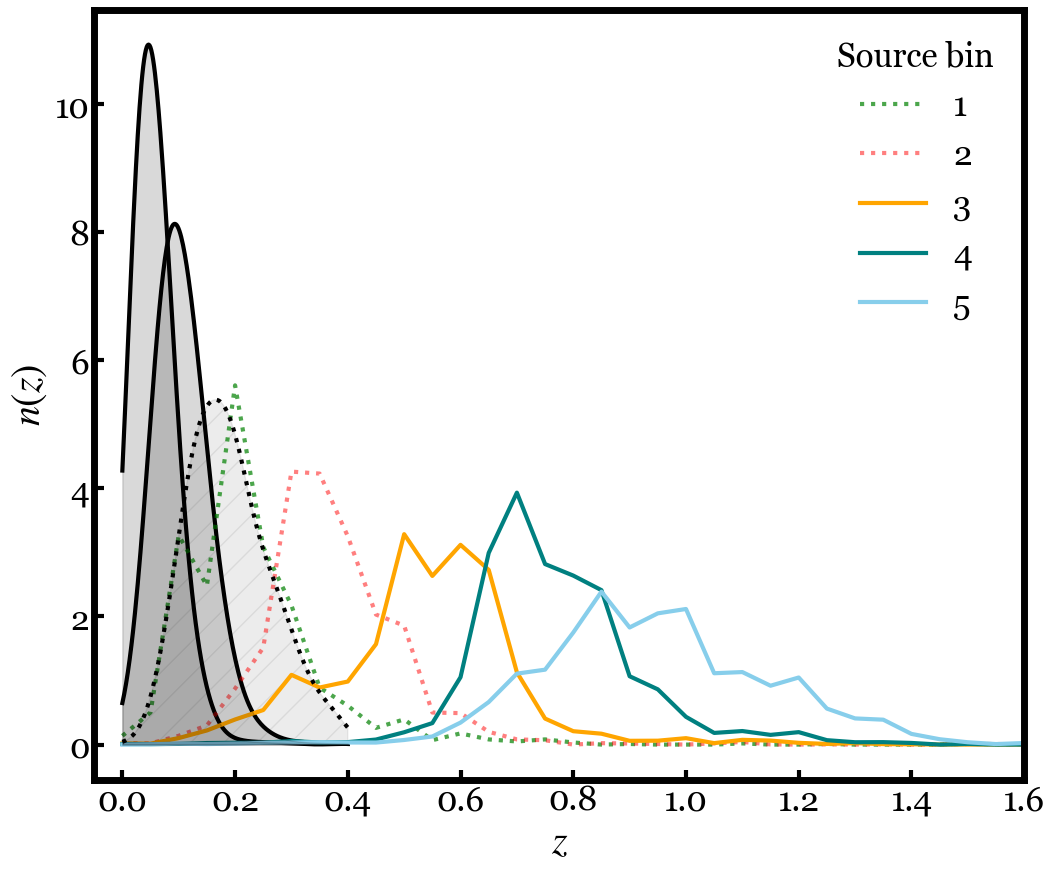

In [18]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(x_z, z_pdf_lo, color = 'black')
ax.fill_between(x_z, z_pdf_lo, color = 'black', alpha = 0.15, zorder = 10)

# ax.plot(x_z, z_pdf_lo/np.sum(z_pdf_lo * x_z), color = 'black')
# ax.fill_between(x_z, z_pdf_lo/np.sum(z_pdf_lo * x_z), color = 'black', alpha = 0.2, zorder = 10)

ax.plot(x_z, z_pdf_md, color = 'black')
ax.fill_between(x_z, z_pdf_md, color = 'black', alpha = 0.15, zorder = 11)

# ax.plot(x_z, z_pdf_md/np.sum(z_pdf_md * x_z), color = 'black')
# ax.fill_between(x_z, z_pdf_md/np.sum(z_pdf_md * x_z), color = 'black', alpha = 0.2, zorder = 11)

ax.plot(x_z, z_pdf_hi, color = 'black', linestyle = ':', zorder = 12)
ax.fill_between(x_z, z_pdf_hi, color = 'black', alpha = 0.075, hatch = '/')

# ax.plot(x_z, z_pdf_hi/np.sum(z_pdf_hi * x_z), color = 'black', linestyle = ':', zorder = 12)
# ax.fill_between(x_z, z_pdf_hi/np.sum(z_pdf_hi * x_z), color = 'black', alpha = 0.1, hatch = '/')

ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin1['col1'], KiDS_SOM_n_z_bin1['col2']),
        alpha = 0.7, linestyle = ':', label = '1', color = 'green')
# ax.fill_between(KiDS_SOM_n_z_bin1['col1'], KiDS_SOM_n_z_bin1['col2'], color = 'lightgreen', alpha = 0.2, hatch = '/', facecolor = 'none')
ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin2['col1'], KiDS_SOM_n_z_bin2['col2']),
        alpha = 0.5, linestyle = ':', label = '2')
# ax.fill_between(KiDS_SOM_n_z_bin2['col1'], KiDS_SOM_n_z_bin2['col2'], alpha = 0.2, hatch = '/', color = 'red', facecolor = 'none')

ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin3['col1'], KiDS_SOM_n_z_bin3['col2']), label = '3')
ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin4['col1'], KiDS_SOM_n_z_bin4['col2']), label = '4')
ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin5['col1'], KiDS_SOM_n_z_bin5['col2']), label = '5')

ax.set_xlim(-0.05, 1.6)

ax.set_xlabel('$z$')
ax.set_ylabel('$n(z)$')

ax.legend(title = 'Source bin', frameon = False)

In [19]:
mstar_lo_idx = [mstar_lo[*index] for index in data_bmus]
mstar_md_idx = [mstar_md[*index] for index in data_bmus]
mstar_hi_idx = [mstar_hi[*index] for index in data_bmus]

In [20]:
mstar_lo_sources = KiDS_predicted[np.arange(0, KiDS_predicted.get_nrows())[mstar_lo_idx]]
mstar_md_sources = KiDS_predicted[np.arange(0, KiDS_predicted.get_nrows())[mstar_md_idx]]
mstar_hi_sources = KiDS_predicted[np.arange(0, KiDS_predicted.get_nrows())[mstar_hi_idx]]

In [21]:
folder = '/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_dwarf_galaxy_candidates_09Aug24_photom'
mstar_lo_catalog = FITS(f'{folder}/KiDS_dwarf_galaxy_bin1.fits', 'rw')
mstar_lo_catalog.write(mstar_lo_sources)
mstar_lo_catalog.close()

mstar_md_catalog = FITS(f'{folder}/KiDS_dwarf_galaxy_bin2.fits', 'rw')
mstar_md_catalog.write(mstar_md_sources)
mstar_md_catalog.close()

mstar_hi_catalog = FITS(f'{folder}/KiDS_dwarf_galaxy_bin3.fits', 'rw')
mstar_hi_catalog.write(mstar_hi_sources)
mstar_hi_catalog.close()

In [23]:
n_z_folder = '/data2/lsajkov/mpdg/data_products/KiDS/WL/n_z_20p5_09Aug24'
mstar_lo_n_z = np.array(list(zip(x_z, z_pdf_lo)))
ascii.write(mstar_lo_n_z, f'{n_z_folder}/n_z_bin1')

mstar_md_n_z = np.array(list(zip(x_z, z_pdf_md)))
ascii.write(mstar_md_n_z, f'{n_z_folder}/n_z_bin2')

mstar_hi_n_z = np.array(list(zip(x_z, z_pdf_hi)))
ascii.write(mstar_hi_n_z, f'{n_z_folder}/n_z_bin3')

Text(0.5, 0.01, '$z$')

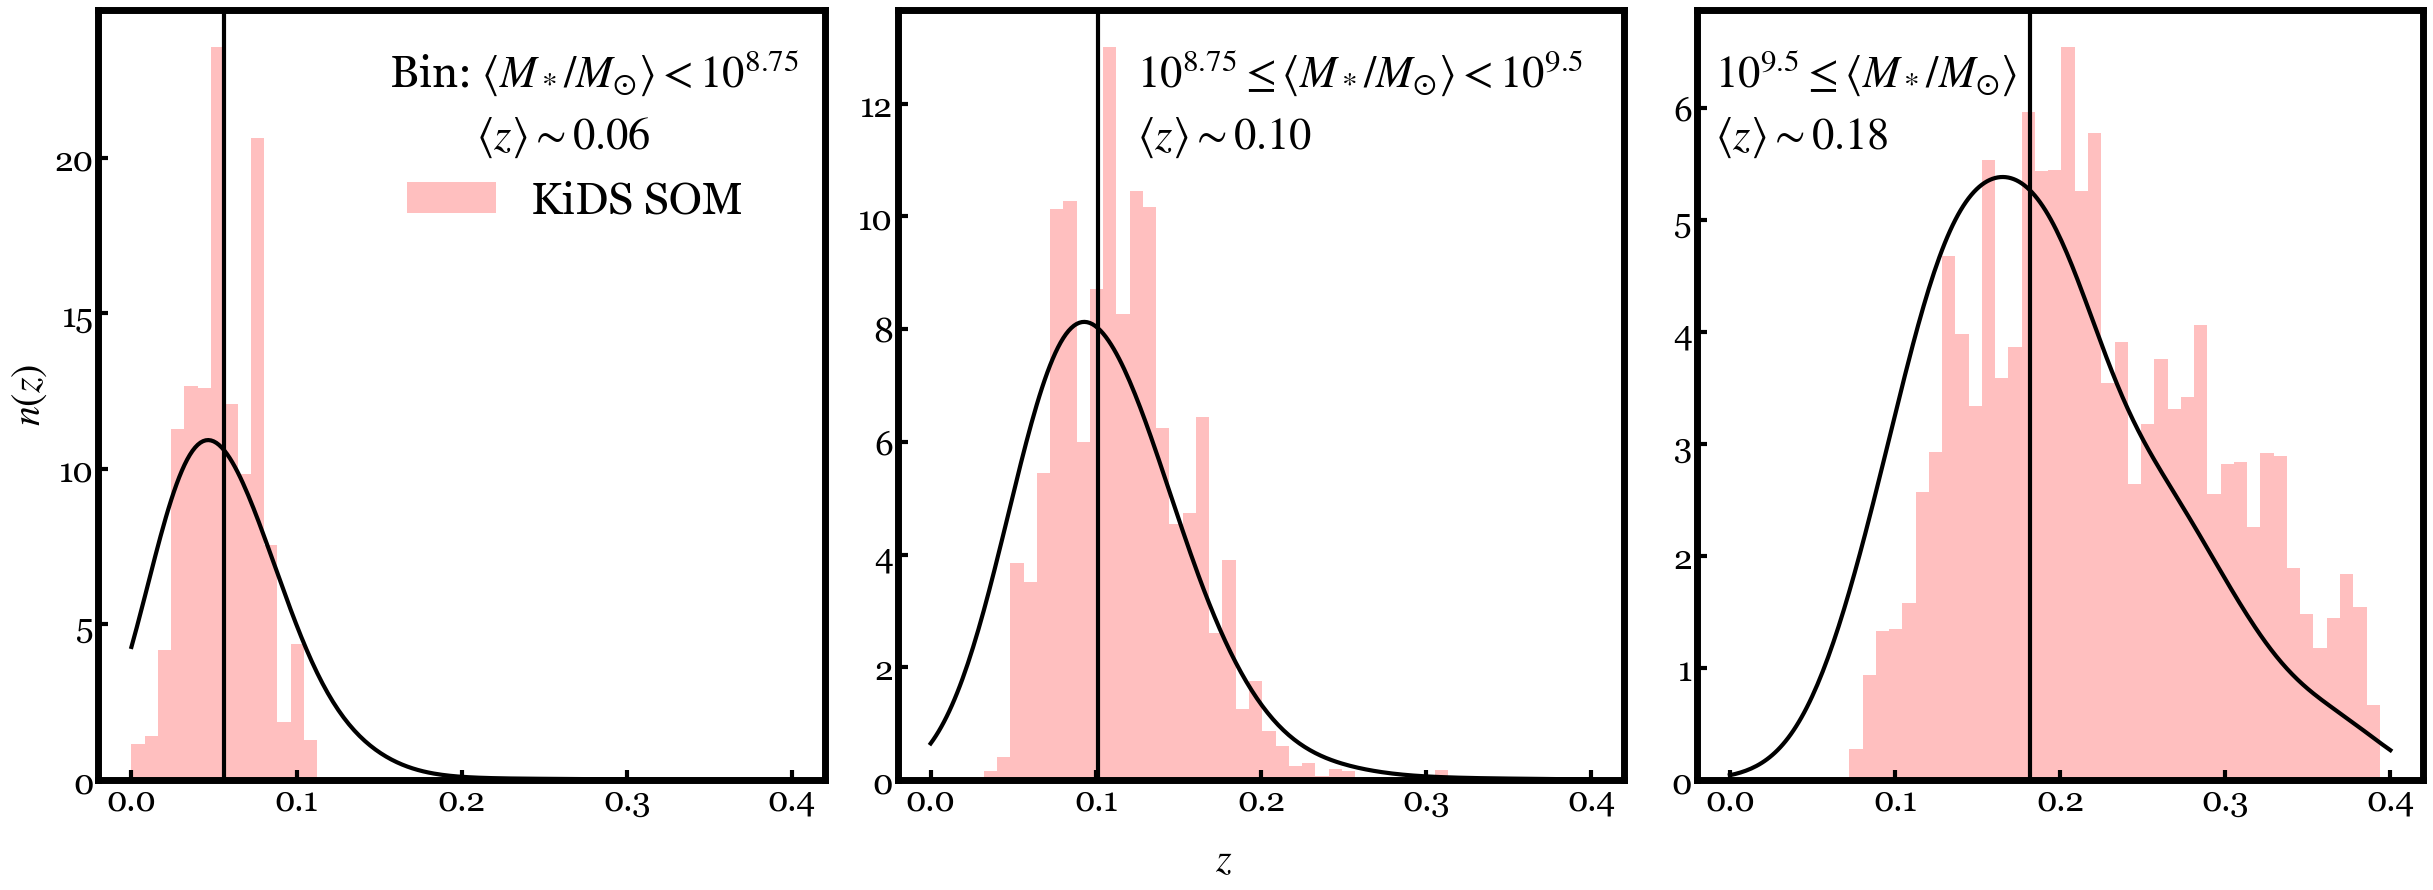

In [27]:
fig = plt.figure(figsize = (30, 10))

bins = mstar_lo_n_z[:, 0][::5]
ax_l = fig.add_subplot(131)

vals = np.histogram(mstar_lo_sources['redshift_pred'], density = True, bins = bins)[0]
ax_l.stairs(vals, bins, fill = True,
            facecolor = ('red', 0.25), label = 'KiDS SOM')
ax_l.plot(mstar_lo_n_z[:, 0], mstar_lo_n_z[:, 1],
          color = 'black', linewidth = 3)
ax_l.axvline(z_median_lo, color = 'black')

ax_l.set_ylabel(r'$n(z)$')

ax_l.text(0.4, 0.9,
          r'Bin: $\langle M_*/M_{\odot} \rangle < 10^{8.75}$',
          transform = ax_l.transAxes, fontsize = 32)

ax_l.text(0.52, 0.82,
          rf'$\langle z \rangle \sim {z_median_lo:.2f}$',
          transform = ax_l.transAxes, fontsize = 32)

ax_l.legend(frameon = False, fontsize = 32,
            loc = (0.4, 0.7))

ax_m = fig.add_subplot(132)

vals = np.histogram(mstar_md_sources['redshift_pred'], density = True, bins = bins)[0]
ax_m.stairs(vals, bins, fill = True,
            facecolor = ('red', 0.25))
ax_m.plot(mstar_md_n_z[:, 0], mstar_md_n_z[:, 1],
          color = 'black', linewidth = 3)
ax_m.axvline(z_median_md, color = 'black')

# ax_m.set_ylim(0, 1.05)
# ax_m.set_yticklabels([])

ax_m.text(0.33, 0.9,
          r'$10^{8.75}\leq \langle M_*/M_{\odot} \rangle < 10^{9.5}$',
          transform = ax_m.transAxes, fontsize = 32)

ax_m.text(0.33, 0.82,
          rf'$\langle z \rangle \sim {z_median_md:.2f}$',
          transform = ax_m.transAxes, fontsize = 32)

ax_r = fig.add_subplot(133)

vals = np.histogram(mstar_hi_sources['redshift_pred'], density = True, bins = bins)[0]
ax_r.stairs(vals, bins, fill = True,
            facecolor = ('red', 0.25))
ax_r.plot(mstar_hi_n_z[:, 0], mstar_hi_n_z[:, 1],
          color = 'black', linewidth = 3)
ax_r.axvline(z_median_hi, color = 'black')

# ax_r.set_ylim(0, 1.05)
# ax_r.set_yticklabels([])

ax_r.text(0.025, 0.9,
          r'$10^{9.5} \leq \langle M_*/M_{\odot} \rangle$',
          transform = ax_r.transAxes, fontsize = 32)

ax_r.text(0.025, 0.82,
          rf'$\langle z \rangle \sim {z_median_hi:.2f}$',
          transform = ax_r.transAxes, fontsize = 32)

fig.subplots_adjust(wspace = 0.1)
fig.supxlabel('$z$')